<h1>0. Function Definition</h1>

In [3]:
import numpy as np
import pandas as pd
from pyvital2 import arr
from pyvital2 import pleth_spi as pleth
import numpy as np
import scipy.stats as st
from scipy.optimize import curve_fit
import os, pickle


#find the nearest value and return idx of the array
def nearest_idx(array_like, target):
    return np.abs(np.array(array_like)-target).argmin()


#make linear connection between two discrete points -> used to calculate RMS
def conn_graph(spi_list, idx):
    # calculate idx of spi
    spi_idx_list = np.where(~np.isnan(spi_list))[0]
    near_idx = nearest_idx(spi_idx_list, idx)
    idx_closest = spi_idx_list[near_idx]
    
    if idx_closest == 0 and idx < spi_idx_list[0]:
        print('device PPG is measured before device SPI is measured')
        #return gp[0] + (gp[1] -gp[0]) / 0.01 * x
    elif idx_closest == len(spi_list)-1 and idx > spi_idx_list[-1]:
        print('device PPG is measured after measuring device SPI')
        return spi_list[idx_closest] + (spi_list[idx_closest] - spi_list[spi_idx_list[near_idx-1]]) \
        / (idx_closest - spi_idx_list[near_idx-1]) * (idx_closest - idx)
    
    # y = f(x_n) + (f(x_n+1) - f(x_n))/(x_n+1 - x_n) * (x - x_n)
    return spi_list[idx_closest] + (spi_list[spi_idx_list[near_idx+1]] - spi_list[idx_closest]) \
    / (spi_idx_list[near_idx+1]-idx_closest) * (idx - idx_closest)     


#calculating rms between two lists
def calc_rms(list1, list2):
    return np.mean((np.array(list1) - np.array(list2)) ** 2) ** 0.5


#calculating y_model for total inputs
#group histogram을 얻기 위해선 일단 모든 sample들을 load해야 하기 때문에 한번에 model의 SPI값을 계산할 수 없음
def run_total_data(x, w_g): 
    x = np.array(x)
    
    hbi_perc_list, ppga_perc_list = np.zeros(len(x)), np.zeros(len(x))
    hbi_perc_list[0:n_lim] = x[0:n_lim,4]
    ppga_perc_list[0:n_lim] = x[0:n_lim,5]
    hbi_perc_list[n_lim:] = x[n_lim:,0] * (1-w_g) + x[n_lim:,4] * w_g
    ppga_perc_list[n_lim:] = x[n_lim:,1] * (1-w_g) + x[n_lim:,5] * w_g
    
    return 100 - (0.7 * hbi_perc_list + 0.3 * ppga_perc_list)

<h1>1. Input</h1>

**sample file path**: ./sample/ <br>
**file name**: sample0, sample1, ...<br>
**file format**: csv extracted from vital record file<br>

<h2>1.1 Defining Group Histogram</h2>

In [14]:
#adding group histogram term
print("created a new group histogram\n")
group_hist_ppga = pleth.Histogram(0, 20, 1000)
group_hist_hbi = pleth.Histogram(240, 2000, 1000)

created a new group histogram



<h2>1.2 Loading Data</h2>

<h3>1.2.1 Loading 6 samples of (HBI, PPGA, x, y)</h3>

<br>Group distribution의 training set이자 모델의 성능 평가로 쓰일 test set
<br>Sample3, Sample7은 SPI값이 없어서 제외

In [15]:
%load_ext autoreload
%autoreload 2

from pyvital2 import vitaldb

srate = 100
#RMS 계산을 위해 model의 SPI가 나오는 dt에서의 device SPI가 필요
y_device= []
#group histogram이 완성되면 model의 SPI 값을 구하기 위한 input
x_model = []

for i in range(1,9):
    cachepath = "cache/hbi_ppga_x_y_" + str(i)
    
    #이미 저장된 pickle 파일이 있으면 loading
    if os.path.exists(cachepath):
        print('loading sample'+str(i)+'...')
        hbi_list, ppga_list, x_mod, y_dev = pickle.load(open(cachepath, 'rb'))
        
        for hbi in hbi_list:
            group_hist_ppga.learn(hbi)
        for ppga in ppga_list:
            group_hist_ppga.learn(ppga)
        
        y_device.append(y_dev)
        x_model.append(x_mod)

        print('loading completed')
        
        
    #저장된 pickle 파일이 없으면 새로 계산해서 저장       
    else: 
        samplepath = 'sample/sample'+str(i)+'.vital'
        if os.path.exists(samplepath):
            res = vitaldb.vital_recs('sample/sample'+str(i)+'.vital', ['Bx50/PLETH', 'Bx50/SPI'], interval = 0.01)
        else:
            print('no existing', samplepath)
            continue
            
        val_pleth = res[:,0]
        val_spi = res[:,1]
        
        print('size of input'+str(i)+':', len(val_pleth))
        val_pleth = arr.exclude_undefined(val_pleth)
        print('trimmed input'+str(i)+':', len(val_pleth))
        
        #이미 저장된 peaks 파일이 있으면 loading
        if os.path.exists('cache/peaks'+str(i)):
            print('loading peaks...')
            minlist, maxlist = pickle.load(open('cache/peaks'+str(i), 'rb'))
            print('loading completed')
        else:
            minlist, maxlist = arr.detect_peaks(val_pleth, 100)
            pickle.dump((minlist, maxlist), open('cache/peaks'+str(i),'wb'))
            print('peaks loaded')

        hbi_list, ppga_list = [], []
        hist_ppga= pleth.Histogram(0, 20, 1000)
        hist_hbi = pleth.Histogram(240, 2000, 1000)
        
        y_dev, x_mod = [], []
        for j in range(len(maxlist) - 1):
            hbi = (maxlist[j+1] - maxlist[j]) / srate * 1000
            if 240 < hbi < 2000:
                group_hist_hbi.learn(hbi)
                hist_hbi.learn(hbi)
                hbi_list.append(hbi)
            ppga = val_pleth[maxlist[j+1]] - val_pleth[minlist[j]]
            if 0 < ppga < 20:
                group_hist_ppga.learn(ppga)
                hist_ppga.learn(ppga)
                ppga_list.append(ppga)
            
            # model의 SPI가 나오는 dt(model은 maxlist 지점에서 SPI 계산)에서의 device SPI 값 (to calculate RMS)
            y_dev.append(conn_graph(val_spi, maxlist[j+1]))
            x_mod.append([hist_hbi.percentile(hbi), hist_ppga.percentile(ppga), hbi, ppga])
       
        y_device.append(y_dev)
        x_model.append(x_mod)
        pickle.dump((hbi_list, ppga_list, x_mod, y_dev), open(cachepath, 'wb'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
size of input1: 2110358
trimmed input1: 2092540
peaks loaded
size of input2: 718587
trimmed input2: 718484
peaks loaded
no existing sample/sample3.vital
size of input4: 740443
trimmed input4: 734000
peaks loaded
size of input5: 581465
trimmed input5: 112079
peaks loaded
size of input6: 732500
trimmed input6: 360037
peaks loaded
no existing sample/sample7.vital
size of input8: 318658
trimmed input8: 318305
peaks loaded


<h3>1.2.2 Loading 19 samples of (HBI, PPGA)</h3>
<br>For training group histogram

In [17]:
from pyvital2 import arr, vitaldb

# 추가 샘플을 group histo 에 집어넣음
for i in range(11,30):
    cachepath = "cache/hbi_ppga" + str(i)
    
    #이미 저장된 pickle 파일이 있으면 loading -> group histogram을 훈련시킴
    if os.path.exists(cachepath):
        print('loading sample'+str(i))
        hbi_list, ppga_list = pickle.load(open(cachepath, 'rb'))
        
        for hbi in hbi_list:
            group_hist_ppga.learn(hbi)
        for ppga in ppga_list:
            group_hist_ppga.learn(ppga)
            
    #저장된 pickle 파일이 없으면 새로 계산해서 저장   
    else:
        vals = vitaldb.vital_recs('sample/sample'+str(i)+'.vital', ['Bx50/PLETH'], interval = 0.01).flatten()
        print('size of sample'+str(i)+':', len(vals))
        vals = arr.exclude_undefined(vals)
        minlist, maxlist = arr.detect_peaks(vals, 100)
        
        hbi_list, ppga_list = [], []
        for j in range(len(maxlist) - 1):
            hbi = (maxlist[j+1] - maxlist[j]) / srate * 1000
            if 240 < hbi < 2000:
                group_hist_hbi.learn(hbi)
                hbi_list.append(hbi)
            ppga = vals[maxlist[j+1]] - vals[minlist[j]]
            if 0 < ppga < 20:
                group_hist_ppga.learn(ppga)
                ppga_list.append(ppga)    
                
        pickle.dump((hbi_list, ppga_list), open(cachepath, 'wb'))

size of sample11: 900675
size of sample12: 956455
size of sample13: 984919
size of sample14: 908273
size of sample15: 920103
size of sample16: 605720
size of sample17: 463998
size of sample18: 914284
size of sample19: 1364624
size of sample20: 2448756
size of sample21: 728158
size of sample22: 230376
size of sample23: 133526
size of sample24: 367400
size of sample25: 734496
size of sample26: 648061
size of sample27: 838725
size of sample28: 856473
size of sample29: 709883


<h3>1.2.3 x_model 에 group histo 결과를 추가함</h3>

In [18]:
print("x_model shape:", np.array(x_model).shape)

#x_model into whole (x_model[i]는 sample i에 해당하는 값으로 sample i를 뒤에서 plot할 때 필요)
x_models = []
for i in range(len(x_model)):
    x_models.extend(x_model[i])
print(np.array(x_models).shape)

x_model shape: (6,)
(53046, 4)


In [19]:
#merge each sample's x_model into x_models
x_models = []
for i in range(len(x_model)):
    x_models.extend(x_model[i])

for i in range(len(x_models)):
    if len(x_models[i]) <= 4:
        x_models[i].append(group_hist_hbi.percentile(x_models[i][2]))
        x_models[i].append(group_hist_ppga.percentile(x_models[i][3]))
    else:
        x_models[i][4] = group_hist_hbi.percentile(x_models[i][2])
        x_models[i][5] = group_hist_ppga.percentile(x_models[i][3])
print("x_models shape:", np.array(x_models).shape)

x_models shape: (53046, 6)


<h1>2. Result</h1>
<h2>2.1. RMS value</h2>

<h3>2.1.1 Results using 8 samples(PPG, SPI) + 19 samples(PPG only) for group histogram learning</h3>

In [20]:
#weight of group histogram - calculated by scipy.optimize.curve_fit
w_g = 0.27
#threshold for using individual distribution
n_lim = 500

#calculating model SPI with full samples
y_model_total = run_total_data(x_models, w_g)
#applying moving average
y_model_moa = pd.DataFrame(y_model_total).rolling(20, min_periods=1).mean().values.flatten()
                           
y_devices = []
for i in range(len(y_device)):
    y_devices.extend(y_device[i])
#printing RMS value
print("RMS of the model: ", calc_rms(y_devices, y_model_moa))

RMS of the model:  21.089843385029344


<h2>2.2 Graph plot</h2>

<h3>Using 6 samples</h3>

<h3>2.2.1 Plotting every 1000 SPIs </h3>

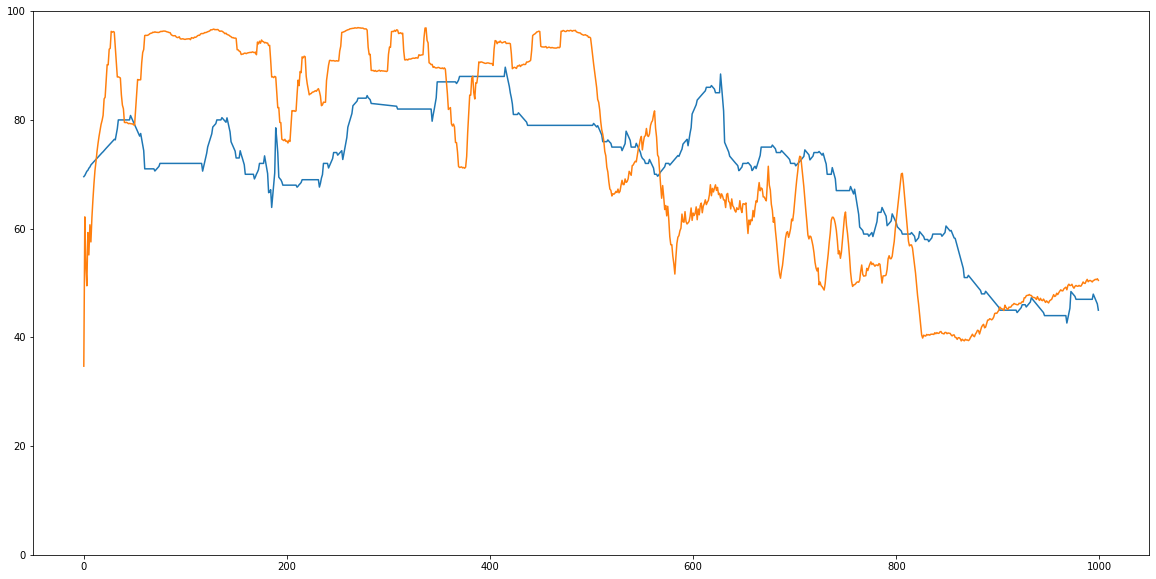

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(0, len(y_device), 1000):
    plt.figure(figsize=(20,10))
    plt.ylim(0,100)
    plt.plot(y_devices[i:i+1000])
    plt.plot(y_model_moa[i:i+1000])
    


<h3>2.2.2 Plotting every samples</h3>

RMS error for sample 1 : 22.32327336754307


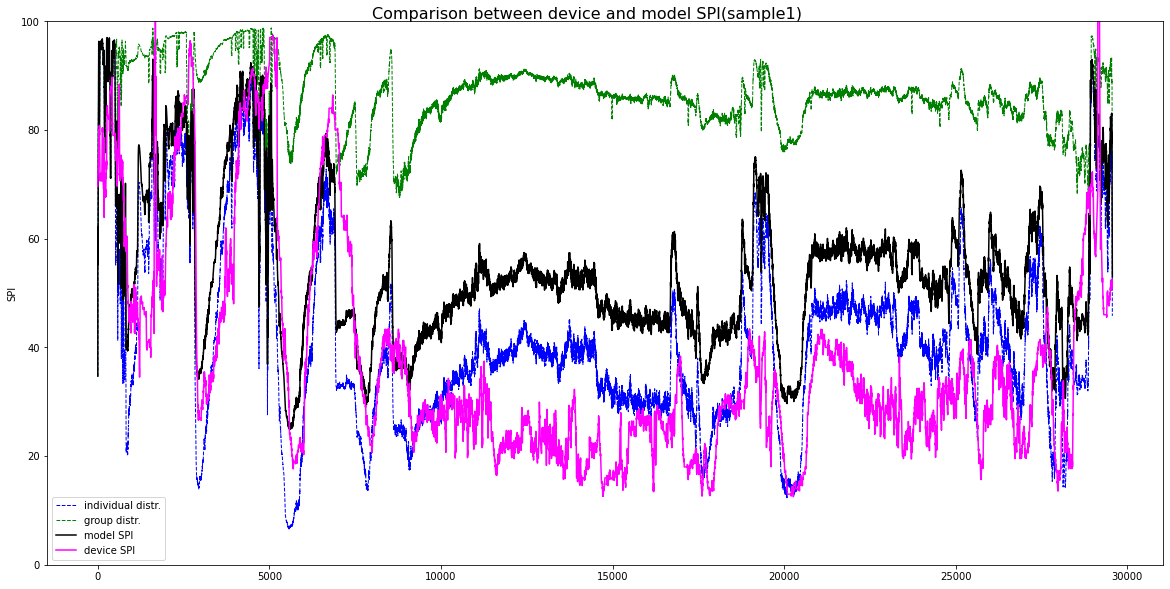

------------------------------------------------------------------------------------------------
RMS error for sample 2 : 17.015384810923962


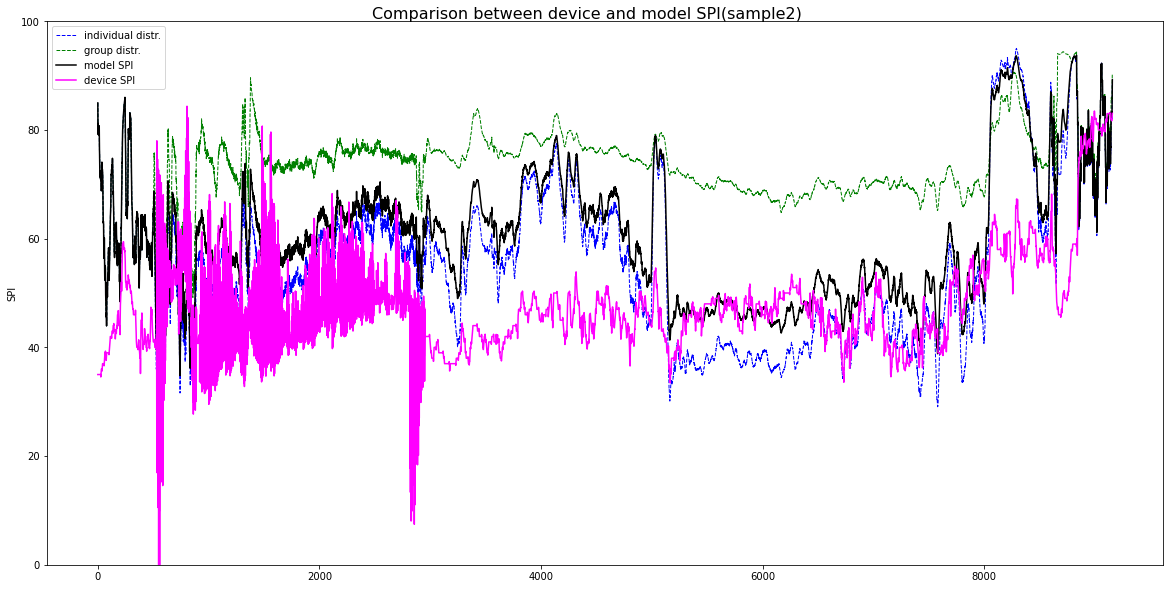

------------------------------------------------------------------------------------------------
RMS error for sample 3 : 16.863460279339847


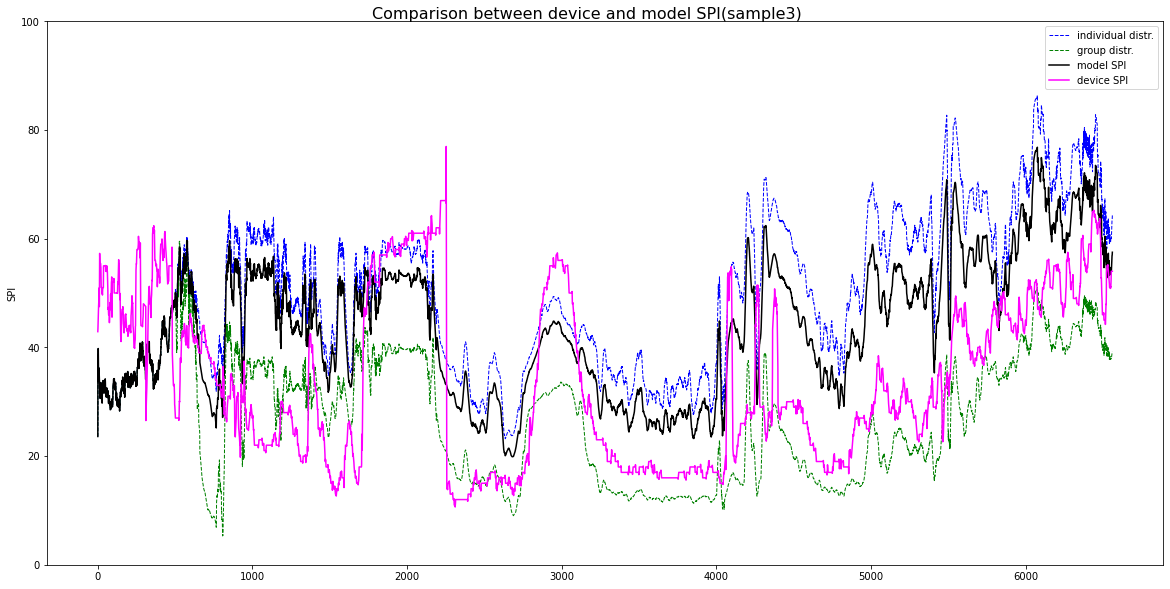

------------------------------------------------------------------------------------------------
RMS error for sample 4 : 23.390546279106626


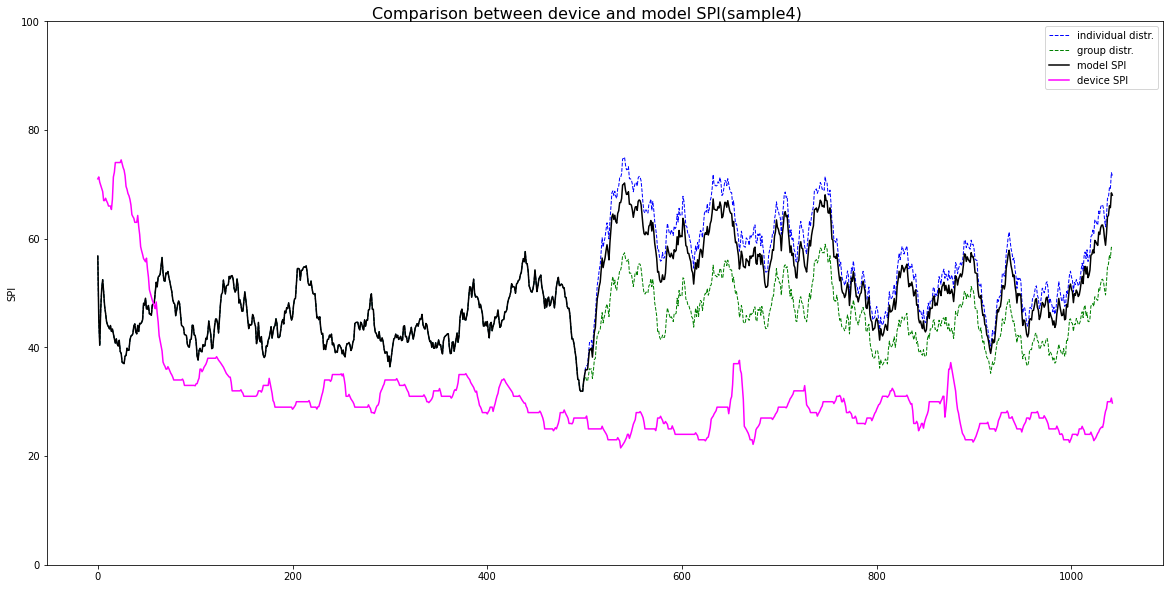

------------------------------------------------------------------------------------------------
RMS error for sample 5 : 30.222075261692336


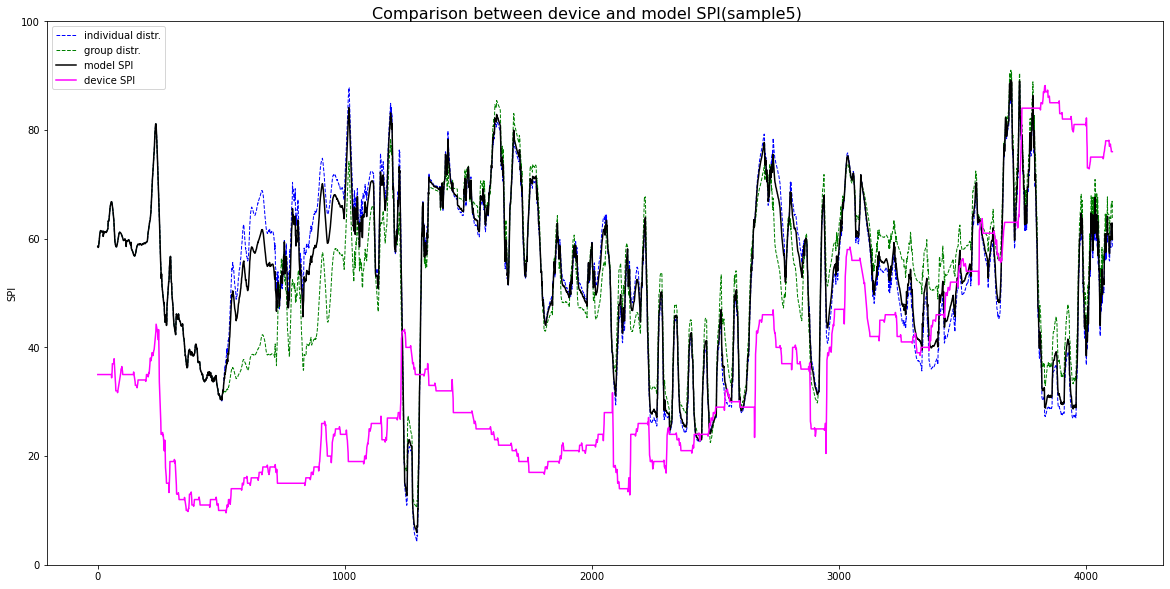

------------------------------------------------------------------------------------------------
RMS error for sample 6 : 12.434356774070777


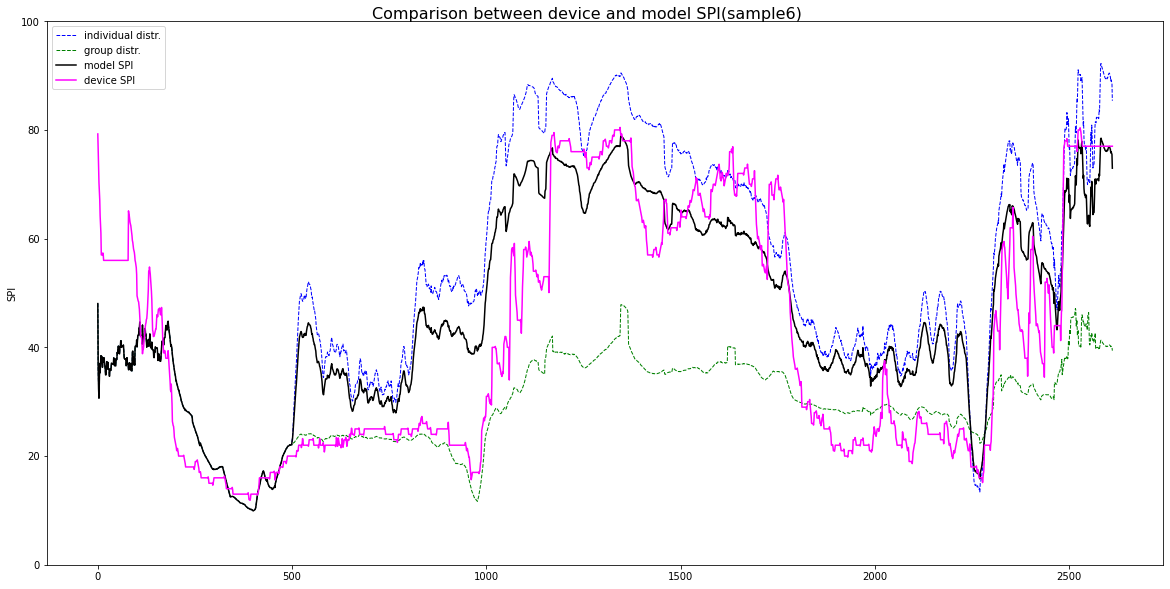

------------------------------------------------------------------------------------------------


IndexError: list index out of range

<Figure size 1440x720 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(len(x_models)):
    fig = plt.figure(figsize=(20,10))
    
    y_mod_samp = run_total_data(x_model[i], w_g)
    y_mod_samp = pd.DataFrame(y_mod_samp).rolling(20, min_periods=1).mean().values.flatten()
    y_mod_w0 = run_total_data(x_model[i], 0)
    y_mod_w0 = pd.DataFrame(y_mod_w0).rolling(20, min_periods=1).mean().values.flatten()
    y_mod_w1 = run_total_data(x_model[i], 1)
    y_mod_w1 = pd.DataFrame(y_mod_w1).rolling(20, min_periods=1).mean().values.flatten()  
    
    print("RMS error for sample", i+1, ":", calc_rms(y_device[i], y_mod_samp))
    fig.suptitle("Comparison between device and model SPI(sample" + str(i+1)+")", y=0.9, fontsize=16)
    
    ax = fig.add_subplot(1,1,1)
    ax.plot(np.arange(len(x_model[i])), y_mod_w0, color='blue', label='individual distr.', linestyle='dashed', linewidth=1)
    ax.plot(np.arange(len(x_model[i])), y_mod_w1, color='green', label='group distr.', linestyle='dashed', linewidth=1)
    ax.plot(np.arange(len(x_model[i])), y_mod_samp, color='black', label='model SPI')
    ax.plot(np.arange(len(x_model[i])), y_device[i], color='magenta', label='device SPI')
    ax.legend(loc = 'best')
    ax.set_ylabel("SPI")
    ax.set_ylim(0,100)
    plt.show()
    print('------------------------------------------------------------------------------------------------')

<h1>3. Appendix</h1>

<h2>3.1 Group histogram</h2>

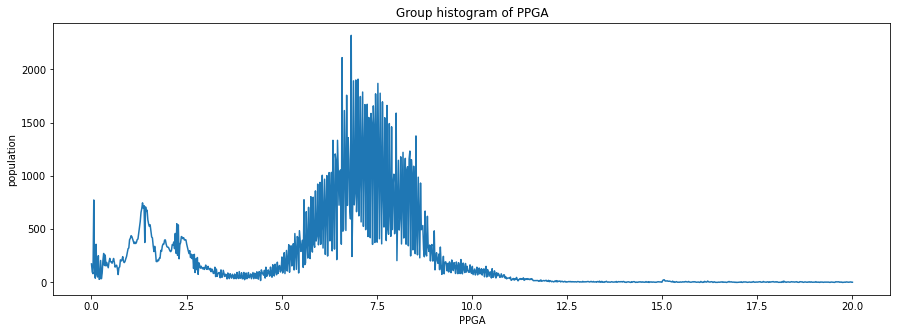

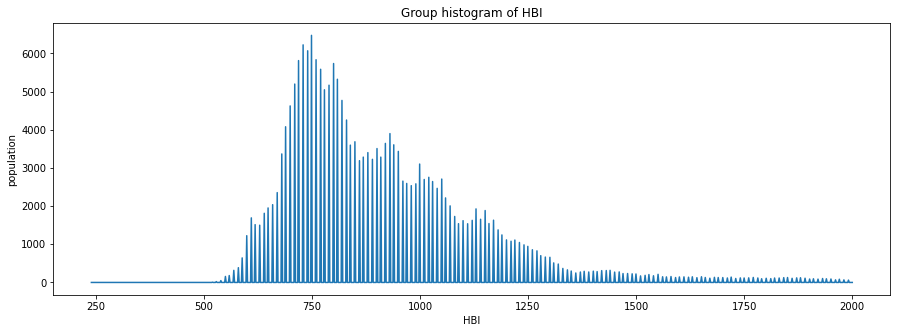

In [22]:
plt.figure(figsize=(15,5))
plt.title('Group histogram of PPGA')
plt.xlabel('PPGA')
plt.ylabel('population')
plt.plot(np.linspace(group_hist_ppga.minval, group_hist_ppga.maxval, 1000), group_hist_ppga.bins)


plt.figure(figsize=(15,5))
plt.title('Group histogram of HBI')
plt.xlabel('HBI')
plt.ylabel('population')
plt.plot(np.linspace(group_hist_hbi.minval, group_hist_hbi.maxval, 1000), group_hist_hbi.bins)
